In [5]:
# Import Stuff
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from multiprocessing import Process
from IPython.display import clear_output
from tensorflow.keras.layers import BatchNormalization


In [6]:
# All Parameters required for training are declared over here
DIR = "Data"
# Frequency of Image Capturing
FRAME_SKIP = 2
# Frame Size
FRAME_SIZE = (150,150)

In [7]:
# Dataset
!rm -r A-Dataset-for-Automatic-Violence-Detection-in-Videos/
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos

'rm' is not recognized as an internal or external command,
operable program or batch file.


^C


In [8]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
! kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
!unzip \*.zip  && rm *.zip
!rm -r ./real\ life\ violence\ situations
clear_output()
print("Extracted")

Extracted


In [12]:

!rm -r Data
!mkdir Data
!mkdir -p ./Data/Video/Violent
!mkdir -p ./Data/Video/NonViolent
!cp -a ./A-Dataset-for-Automatic-Violence-Detection-in-Videos/violence-detection-dataset/violent/cam1/. ./Data/Video/Violent/
!cp -a ./Real\ Life\ Violence\ Dataset/Violence/. ./Data/Video/Violent/
!cp -a ./Real\ Life\ Violence\ Dataset/NonViolence/. ./Data/Video/NonViolent/
!cp -a ./A-Dataset-for-Automatic-Violence-Detection-in-Videos/violence-detection-dataset/non-violent/cam1/. ./Data/Video/NonViolent/
clear_output()
!mkdir -p ./Data/Training/V
!mkdir -p ./Data/Training/NV
!mkdir -p ./Data/Testing/V
!mkdir -p ./Data/Testing/NV

The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [13]:
# A custom class for extracting image assets from videos
import cv2, os
class Extractor(object):
    def __init__(self, FRAME_SIZE = (150, 150), FRAME_SKIP = 10, Train = True):
        self.size = FRAME_SIZE
        self.count = 0
        self.skip = FRAME_SKIP
        if Train:
            self.dir = './Data/Training/'
        else:
            self.dir = './Data/Testing/'

    def extract(self, path, DIR = 'tmp'):
        folder = self.dir+ DIR
        cap = cv2.VideoCapture(path)   # capturing the video from the given path
        while True:
            frame = []
            stat = True
            for i in range(self.skip):
                ret, frame = cap.read()
                if ret is False:
                    stat = False
                    break
            if stat is False:
                break
            frame = cv2.resize(frame, self.size)
            fname = '%s/%d.jpeg' % (folder, self.count)
            cv2.imwrite(fname, frame)
            self.count += 1
        # cap.release()

In [14]:
def thread_1():
    ext = Extractor(FRAME_SIZE, FRAME_SKIP)
    for i in range(60):
        path = f"./Data/Video/Violent/{i+1}.mp4"
        print(f"Processing Violent {i}")
        ext.extract(path, 'V')

    for i in range(800):
        path = f"./Data/Video/Violent/V_{i+1}.mp4"
        print(f"Processing Violent V_{i}")
        ext.extract(path, 'V')

    print("Violent Extracted")

def thread_2():
    ext = Extractor(FRAME_SIZE, FRAME_SKIP)
    for i in range(60):
        path = f"/content/Data/Video/NonViolent/{i+1}.mp4"
        print(f"Processing NonViolent {i}")
        ext.extract(path, 'NV')
    
    for i in range(800):
        path = f"/content/Data/Video/NonViolent/NV_{i+1}.mp4"
        print(f"Processing NonViolent NV_{i}")
        ext.extract(path, 'NV')

    print("Non-Violent Extracted")

def thread_3():
    ext = Extractor(FRAME_SIZE, FRAME_SKIP, Train=False)
    
    for i in range(800, 1000):
        path = f"./Data/Video/Violent/V_{i+1}.mp4"
        print(f"Processing Violent V_{i}")
        ext.extract(path, 'V')

    print("Violent Extracted")

def thread_4():
    ext = Extractor(FRAME_SIZE, FRAME_SKIP, Train=False)
    for i in range(800, 1000):
        path = f"/content/Data/Video/NonViolent/NV_{i+1}.mp4"
        print(f"Processing NonViolent NV_{i}")
        ext.extract(path, 'NV')

    print("Non-Violent Extracted")



In [15]:
# Violent Extraction
t1 = Process(target=thread_1, args=())
t2 = Process(target=thread_2, args=())
t3 = Process(target=thread_3, args=())
t4 = Process(target=thread_4, args=())

t1.start() 
t2.start()
t3.start() 
t4.start()
# NonViolent Extraction

t1.join()
t2.join()
t3.join()
t4.join()

clear_output()
print("Complete")

Complete


In [16]:
# Let the training Begin
base_dir='./Data'
train_dir=os.path.join(base_dir,'Training')
test_dir=os.path.join(base_dir,"Testing")

train_violent_dir =os.path.join(train_dir, 'V' )
train_nonviolent_dir=os.path.join(train_dir,'NV')
test_violent_dir=os.path.join(test_dir,'V')
test_nonviolent_dir=os.path.join(test_dir,'NV')


In [17]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=40,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,horizontal_flip=True, fill_mode='nearest')

In [18]:
test_datagen =ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_directory(train_dir,color_mode="rgb", target_size = (150,150),batch_size=20,classes=['NV','V'], class_mode='binary', shuffle=True)

Found 0 images belonging to 2 classes.


In [20]:
validation_generator = test_datagen.flow_from_directory(test_dir,color_mode='rgb',target_size=(150,150),batch_size=20,classes=['NV','V'], class_mode='binary',shuffle=True)

Found 0 images belonging to 2 classes.


//CNN model architecture , basic customised Convolutional Neural Network 


In [21]:
model= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(1,activation ='sigmoid')

])

In [22]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
history=model.fit(train_generator,steps_per_epoch=50, epochs=50, validation_data=validation_generator,validation_steps=50,verbose=2)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

VGG Net with Keras

In [24]:
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Activation
custom_vgg = Sequential()
custom_vgg.add(Conv2D(32, (3, 3), strides = 1, padding = "same", activation = "relu", input_shape = (150, 150, 3)))
custom_vgg.add(Dropout(0.4))
custom_vgg.add(Conv2D(32, (3, 3), strides = 1, padding = "same", activation = "relu"))
custom_vgg.add(Dropout(0.4))
custom_vgg.add(MaxPooling2D((2, 2)))

custom_vgg.add(Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu"))
custom_vgg.add(Dropout(0.4))
custom_vgg.add(Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu"))
custom_vgg.add(Dropout(0.4))
custom_vgg.add(MaxPooling2D((2, 2)))

custom_vgg.add(Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu"))
custom_vgg.add(Dropout(0.4))
custom_vgg.add(Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu"))
custom_vgg.add(Dropout(0.4))
custom_vgg.add(MaxPooling2D((2, 2)))

custom_vgg.add(Flatten())
custom_vgg.add(Dense(1, activation = "softmax"))

custom_vgg.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

custom_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 dropout_1 (Dropout)         (None, 150, 150, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 dropout_2 (Dropout)         (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                      

In [75]:
history=custom_vgg.fit(train_generator, steps_per_epoch= 30, epochs=50, validation_data=validation_generator,validation_steps=50,verbose=2)

Epoch 1/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5333 - val_loss: 0.0000e+00 - val_accuracy: 0.4980
Epoch 2/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5583 - val_loss: 0.0000e+00 - val_accuracy: 0.5140
Epoch 3/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5533 - val_loss: 0.0000e+00 - val_accuracy: 0.5310
Epoch 4/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5917 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 5/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5533 - val_loss: 0.0000e+00 - val_accuracy: 0.5340
Epoch 6/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5817 - val_loss: 0.0000e+00 - val_accuracy: 0.5020
Epoch 7/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5567 - val_loss: 0.0000e+00 - val_accuracy: 0.5380
Epoch 8/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.6000 - val_loss: 0.0000e+00 - val_accuracy: 0.5060
Epoch 9/50
30/30 - 4s - loss: 0.0000e+00 - accuracy: 0.5967 - val_loss: 0.0000e+00 - val_accuracy: 0.5270
Epoch 10/50
30/30 - 4s - loss: 0.0000e+00 - ac

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

Cloning into 'A-Dataset-for-Automatic-Violence-Detection-in-Videos'...
Updating files:  14% (52/355)
Updating files:  15% (54/355)
Updating files:  16% (57/355)
Updating files:  17% (61/355)
Updating files:  18% (64/355)
Updating files:  19% (68/355)
Updating files:  20% (71/355)
Updating files:  21% (75/355)
Updating files:  22% (79/355)
Updating files:  23% (82/355)
Updating files:  24% (86/355)
Updating files:  25% (89/355)
Updating files:  26% (93/355)
Updating files:  27% (96/355)
Updating files:  28% (100/355)
Updating files:  29% (103/355)
Updating files:  30% (107/355)
Updating files:  31% (111/355)
Updating files:  32% (114/355)
Updating files:  33% (118/355)
Updating files:  33% (119/355)
Updating files:  34% (121/355)
Updating files:  35% (125/355)
Updating files:  36% (128/355)
Updating files:  37% (132/355)
Updating files:  38% (135/355)
Updating files:  39% (139/355)
Updating files:  40% (142/355)
Updating files:  41% (146/355)
Updating files:  42% (150/355)
Updating file

ResNet (Residual Network) //connecting a layer to the previous as well as previous of previous for better incorporation.


In [80]:
model_AlexNet=keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(150,150,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1024, activation='relu'),

    keras.layers.Dense(1, activation='softmax')])


model_AlexNet.compile(loss='binary_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])
model_AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 35, 35, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 35, 96)        384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 17, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 256)       1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 384)        

In [82]:
history=model_AlexNet.fit(train_generator,epochs=50, steps_per_epoch=50,validation_data=validation_generator,validation_steps=20,verbose=2)

Epoch 1/50
50/50 - 6s - loss: 0.6754 - accuracy: 0.5840 - val_loss: 0.7689 - val_accuracy: 0.5675
Epoch 2/50
50/50 - 6s - loss: 0.6782 - accuracy: 0.5710 - val_loss: 0.7668 - val_accuracy: 0.5200
Epoch 3/50
50/50 - 6s - loss: 0.6605 - accuracy: 0.5840 - val_loss: 0.7203 - val_accuracy: 0.5025
Epoch 4/50
50/50 - 6s - loss: 0.6616 - accuracy: 0.5900 - val_loss: 0.7871 - val_accuracy: 0.5500
Epoch 5/50
50/50 - 6s - loss: 0.6663 - accuracy: 0.5940 - val_loss: 0.7863 - val_accuracy: 0.5475
Epoch 6/50
50/50 - 6s - loss: 0.6231 - accuracy: 0.5920 - val_loss: 0.7809 - val_accuracy: 0.5500
Epoch 7/50
50/50 - 6s - loss: 0.6550 - accuracy: 0.5720 - val_loss: 0.7893 - val_accuracy: 0.5500
Epoch 8/50
50/50 - 6s - loss: 0.6358 - accuracy: 0.5840 - val_loss: 0.8443 - val_accuracy: 0.5125
Epoch 9/50
50/50 - 6s - loss: 0.6090 - accuracy: 0.6370 - val_loss: 0.8078 - val_accuracy: 0.5175
Epoch 10/50
50/50 - 6s - loss: 0.6303 - accuracy: 0.5580 - val_loss: 0.7523 - val_accuracy: 0.5225
Epoch 11/50
50/50 -

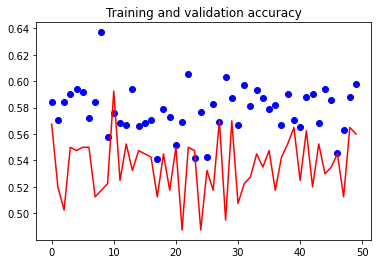

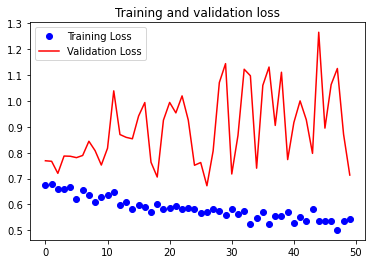

In [83]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [84]:
import time
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
model_AlexNet.save(export_path_keras)

./1611941883.h5


#Inception

In [107]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model
 
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
visible = Input(shape=(150, 150, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model




# summarize model





TypeError: ignored

In [19]:
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.optimizers import RMSprop 

base_model = InceptionV3(input_shape = (150, 150, 3),  
                                include_top = False,  
                                weights = 'imagenet') 
for layer in base_model.layers: 
  layer.trainable = False
  
#stop training is model accuracy reached 99% 
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('acc')>0.99): 
      self.model.stop_training = True


x = layers.Flatten()(base_model.output) 
x = layers.Dense(1024, activation='relu')(x) 
x = layers.Dropout(0.2)(x)                   
x = layers.Dense  (1, activation='sigmoid')(x)            
  
model5 = Model( base_model.input, x)  
  
model5.compile(optimizer = RMSprop(lr=0.0001),loss = 'binary_crossentropy',metrics = ['acc']) 
callbacks = myCallback() 
  
history = model5.fit( 
            train_generator, 
            validation_data = validation_generator, 
            steps_per_epoch = 100, 
            epochs = 30, 
            validation_steps = 50, 
            verbose = 2, 
            callbacks=[callbacks]) 

Epoch 1/30
100/100 - 17s - loss: 1.3647 - acc: 0.6665 - val_loss: 1.0216 - val_acc: 0.5730
Epoch 2/30
100/100 - 12s - loss: 0.6142 - acc: 0.7325 - val_loss: 0.5287 - val_acc: 0.7470
Epoch 3/30
100/100 - 12s - loss: 0.5669 - acc: 0.7565 - val_loss: 0.5330 - val_acc: 0.7890
Epoch 4/30
100/100 - 12s - loss: 0.5476 - acc: 0.7725 - val_loss: 0.9996 - val_acc: 0.6680
Epoch 5/30
100/100 - 12s - loss: 0.5030 - acc: 0.7825 - val_loss: 0.4695 - val_acc: 0.8040
Epoch 6/30
100/100 - 12s - loss: 0.4792 - acc: 0.8015 - val_loss: 0.5134 - val_acc: 0.7700
Epoch 7/30
100/100 - 12s - loss: 0.4524 - acc: 0.8045 - val_loss: 0.6275 - val_acc: 0.7590
Epoch 8/30
100/100 - 12s - loss: 0.4372 - acc: 0.8165 - val_loss: 0.5152 - val_acc: 0.7820
Epoch 9/30
100/100 - 12s - loss: 0.4172 - acc: 0.8300 - val_loss: 0.5960 - val_acc: 0.7360
Epoch 10/30
100/100 - 12s - loss: 0.4298 - acc: 0.8185 - val_loss: 0.7904 - val_acc: 0.7300
Epoch 11/30
100/100 - 13s - loss: 0.4182 - acc: 0.8340 - val_loss: 0.7462 - val_acc: 0.76

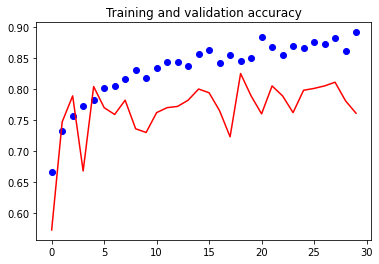

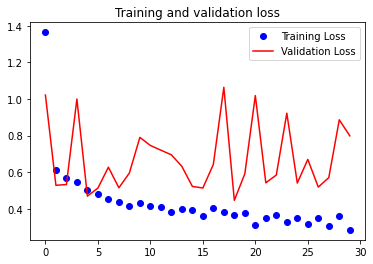

In [21]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
import time
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
model5.save(export_path_keras)

./1611955875.h5


In [118]:
import time
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
.save(export_path_keras)

./1611947709.h5


In [ ]:
model= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(1,activation ='sigmoid')

])

In [91]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [90]:
history=model.fit(train_generator, steps_per_epoch=100,epochs=100,validation_data=validation_generator,validation_steps=50,verbose=2)

Epoch 1/100


InvalidArgumentError: ignored